<a href="https://colab.research.google.com/github/PavelStelmakhV/hw310-keras-fasion-mnist/blob/main/keras_fasion_mnist_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import regularizers
from keras import callbacks

In [170]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [171]:
# x_train = x_train.reshape(60000, 784).astype('float32') / 255
# x_test = x_test.reshape(10000, 784).astype('float32') / 255
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

# Перемешаем тренировочные данные
# train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [172]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [173]:
model = tf.keras.Sequential()

drop_out = 0.3
lern_rat = 0.0001
neurons = 512

model.add(layers.Flatten(input_shape=(28, 28)))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(neurons, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
model.add(layers.Dropout(drop_out))
model.add(layers.Dense(neurons * 2, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
model.add(layers.Dropout(drop_out))

model.add(layers.Dense(neurons * 4, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
model.add(layers.Dropout(drop_out))
model.add(layers.Dense(neurons * 8, activation='relu', kernel_regularizer=regularizers.l2(lern_rat)))
model.add(layers.Dropout(drop_out))
# model.add(layers.Dense(neurons, activation='tanh', kernel_regularizer=regularizers.l2(lern_rat)))
# model.add(layers.Dropout(drop_out))

model.add(layers.Dense(10, activation='softmax'))
# model.add(layers.Softmax())

In [174]:
model.compile(#optimizer='adam',
              optimizer='adamax',
              # optimizer='nadam',
              # optimizer='rmsprop',
              # optimizer='sgd',
              # optimizer='adadelta',
              # loss='binary_crossentropy',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy'])

In [175]:
callback = callbacks.EarlyStopping(monitor='val_loss', patience=12)

In [176]:
# model.fit(train_images, train_labels, epochs=20)
history = model.fit(x_train, y_train,
                    epochs=120,
                    batch_size=32,
                    callbacks=[callback],
                    verbose=1, #многословие
                    validation_data=(x_val, y_val))
test_loss, test_acc = model.evaluate(x_test, y_test)
print('\nTest accuracy:', test_acc)

Epoch 1/120
1563/1563 [==============================] - 16s 8ms/step - loss: 0.9508 - sparse_categorical_accuracy: 0.8027 - val_loss: 0.7254 - val_sparse_categorical_accuracy: 0.8512
Epoch 2/120
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6867 - sparse_categorical_accuracy: 0.8475 - val_loss: 0.5914 - val_sparse_categorical_accuracy: 0.8655
Epoch 3/120
1563/1563 [==============================] - 12s 7ms/step - loss: 0.5801 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.5302 - val_sparse_categorical_accuracy: 0.8704
Epoch 4/120
1563/1563 [==============================] - 12s 7ms/step - loss: 0.5186 - sparse_categorical_accuracy: 0.8694 - val_loss: 0.5060 - val_sparse_categorical_accuracy: 0.8714
Epoch 5/120
1563/1563 [==============================] - 12s 7ms/step - loss: 0.4811 - sparse_categorical_accuracy: 0.8755 - val_loss: 0.4986 - val_sparse_categorical_accuracy: 0.8655
Epoch 6/120
1563/1563 [==============================] - 12s 7ms/step - loss: 0.

In [177]:
print('\nhistory dict:', list(history.history.keys()))


history dict: ['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy']


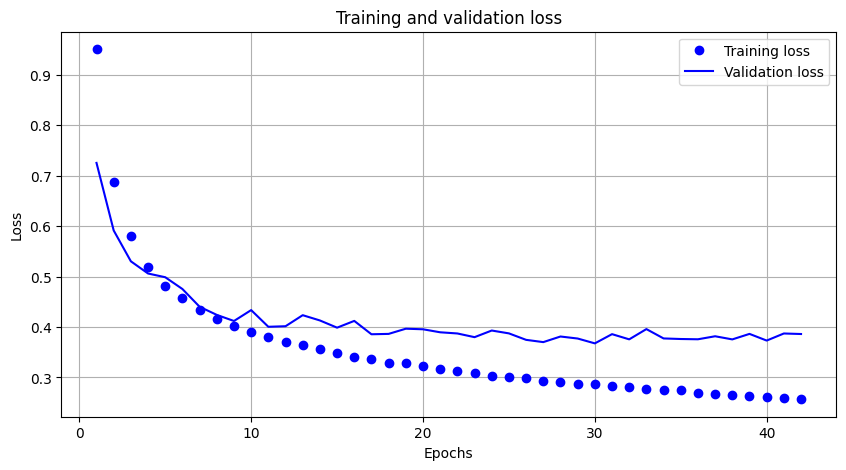

<Figure size 640x480 with 0 Axes>

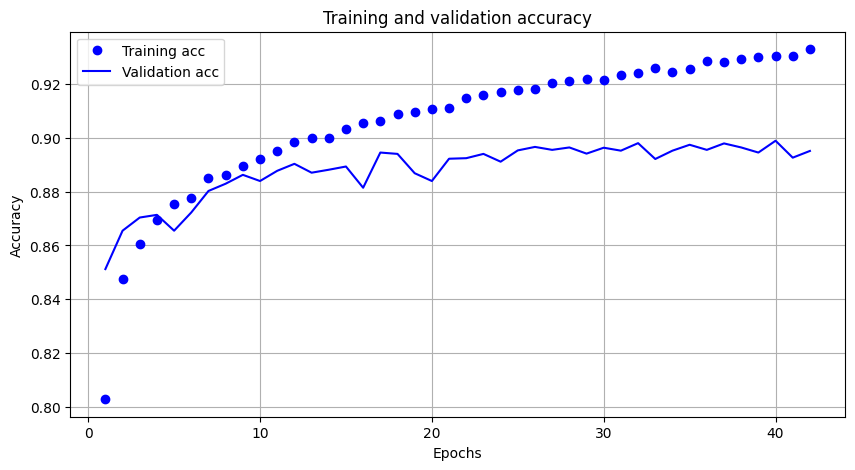

In [178]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['loss']) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.clf()
plt.figure(figsize=(10, 5))
val_acc_values = history_dict['sparse_categorical_accuracy']
plt.plot(epochs, history_dict['sparse_categorical_accuracy'], 'bo', label='Training acc')
plt.plot(epochs, history_dict['val_sparse_categorical_accuracy'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [179]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [180]:
predictions = probability_model.predict(x_test)

313/313 [==============================] - 1s 1ms/step


In [181]:
predictions[0]

array([0.08534196, 0.0853419 , 0.08534196, 0.08534188, 0.08534189,
       0.08534411, 0.08534215, 0.08537403, 0.08534203, 0.23188813],
      dtype=float32)

In [182]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_60 (Dense)            (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_61 (Dense)            (None, 1024)              525312    
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_62 (Dense)            (None, 2048)              2099200   
                                                                 
 dropout_2 (Dropout)         (None, 2048)            